In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas_datareader as pdr
import datetime
today = datetime.date.today()
from matplotlib.ticker import ScalarFormatter

In [3]:
def Black_Scholes_price(S, K, T, r, q, sigma, option_type):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        option_price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        delta = norm.cdf(d1)
    elif option_type == 'put':
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)
        delta = -norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")
    gamma = np.exp(-q * T) * norm.pdf(d1) / (S * sigma * np.sqrt(T))
    theta = -S * norm.pdf(d1) * sigma / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * q * np.exp(-q * T) * norm.cdf(d2) 
    vega = S * np.exp(-q * T) * norm.pdf(d1) * np.sqrt(T)
    
    return option_price, delta, gamma, theta, vega

In [5]:
def Get_rfr():
    risk_free_rate = pd.DataFrame()
    shifted_date = 0 # change this if you run this on a non-trading day, just in case
    while risk_free_rate.empty:
        risk_free_rate = pdr.DataReader('DGS3MO', 'fred', today - datetime.timedelta(days=shifted_date)).dropna()
        shifted_date += 1
    return risk_free_rate.values[0][0]/100

In [93]:
ticker = yf.Ticker('DJT')
expiration = ticker.options[0]
Maturity = float( (datetime.datetime.strptime(expiration, '%Y-%m-%d').date() - today).days)

option_chain = ticker.option_chain(expiration)
calls = option_chain.calls
puts = option_chain.puts

current_price = ticker.info['currentPrice']
price_error = 1/100 #2%

risk_free_rate = Get_rfr()

In [94]:
filtered_calls = calls[ (calls['strike'] >= current_price * (1-price_error)) & (calls['strike'] <= current_price * (1+price_error))]
filtered_puts = puts[ (puts['strike'] >= current_price * (1-price_error)) & (puts['strike'] <= current_price * (1+price_error))]

filtered_calls['Mid_price'] = (filtered_calls['bid'] + filtered_calls['ask'])/2
filtered_puts['Mid_price'] = (filtered_puts['bid'] + filtered_puts['ask'])/2

/var/folders/8d/cgrbd3xs3m97xzpgj1zs6j1m0000gn/T/ipykernel_75788/2674253807.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_calls['Mid_price'] = (filtered_calls['bid'] + filtered_calls['ask'])/2
/var/folders/8d/cgrbd3xs3m97xzpgj1zs6j1m0000gn/T/ipykernel_75788/2674253807.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_puts['Mid_price'] = (filtered_puts['bid'] + filtered_puts['ask'])/2


In [95]:
filtered_calls

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,Mid_price
66,DJT241101C00045000,2024-10-28 17:51:09+00:00,45.0,4.9,4.85,4.95,2.9,144.27863,16859.0,2757,2.29102,True,REGULAR,USD,4.9


In [99]:
filtered_puts

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,Mid_price
67,DJT241101P00045000,2024-10-28 17:50:18+00:00,45.0,4.2,4.1,4.25,-3.97,-48.592415,5267,29,2.030278,False,REGULAR,USD,4.175


In [101]:
filtered_calls['TheoreticalPrice'],filtered_calls['delta'],filtered_calls['gamma'],filtered_calls['theta'],filtered_calls['vega'] = Black_Scholes_price(current_price, filtered_calls['strike'], Maturity/360, risk_free_rate, 0, filtered_calls['impliedVolatility'], 'call')
filtered_puts['TheoreticalPrice'],filtered_puts['delta'],filtered_puts['gamma'],filtered_puts['theta'],filtered_puts['vega'] = Black_Scholes_price(current_price, filtered_puts['strike'], Maturity/360, risk_free_rate, 0, filtered_puts['impliedVolatility'], 'put')


/var/folders/8d/cgrbd3xs3m97xzpgj1zs6j1m0000gn/T/ipykernel_75788/4273540618.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_calls['TheoreticalPrice'],filtered_calls['delta'],filtered_calls['gamma'],filtered_calls['theta'],filtered_calls['vega'] = Black_Scholes_price(current_price, filtered_calls['strike'], Maturity/360, risk_free_rate, 0, filtered_calls['impliedVolatility'], 'call')
/var/folders/8d/cgrbd3xs3m97xzpgj1zs6j1m0000gn/T/ipykernel_75788/4273540618.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

In [337]:
def Payoff(calls,puts):
    Delta = sum(calls['delta'].values + puts['delta'].values)
    Portfolio_0 = calls['Mid_price'].sum() + puts['Mid_price'].sum()  - Delta*current_price

    possible_prices = np.linspace(current_price*0.1,current_price*1.5,1000)
    Profits = np.zeros(len(possible_prices))
    for i, price in enumerate(possible_prices):
        
        call_profit = np.maximum(price - calls['strike'], 0)
        
        put_profit = np.maximum(puts['strike'] - price, 0)
        
        Profits[i] = (call_profit.sum() + put_profit.sum() - Delta*price)

    # Calculate break-even points
    break_even_indices = np.where(np.isclose(Profits, 0, atol=1e-2))[0]
    break_even_prices = possible_prices[break_even_indices]

    
    plt.figure(figsize=(10, 6))
    plt.plot(possible_prices, Profits)
    plt.title('Portfolio Risk Profile')
    plt.xlabel('Underlying Price')
    plt.ylabel('Profit/Loss')
    
    plt.axhline(y=0, color='r', linestyle='--')
    plt.axvline(x=current_price, color='g', linestyle='--', label='Current Price')
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.63, 0.7, f'Current Price: {current_price:.2f} USD', transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='center', bbox=props)
    plt.legend()
    plt.grid(True)

    for k, price in enumerate(break_even_prices):
        print(k)
        plt.plot(price, 0, 'bo')  # blue circle marker
        prop = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        plt.text(0.45 + (k)/2.5, 0.2, f'Break even at: {price:.2f} USD', transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='center', bbox=props)

    
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    #ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.show()

0
1


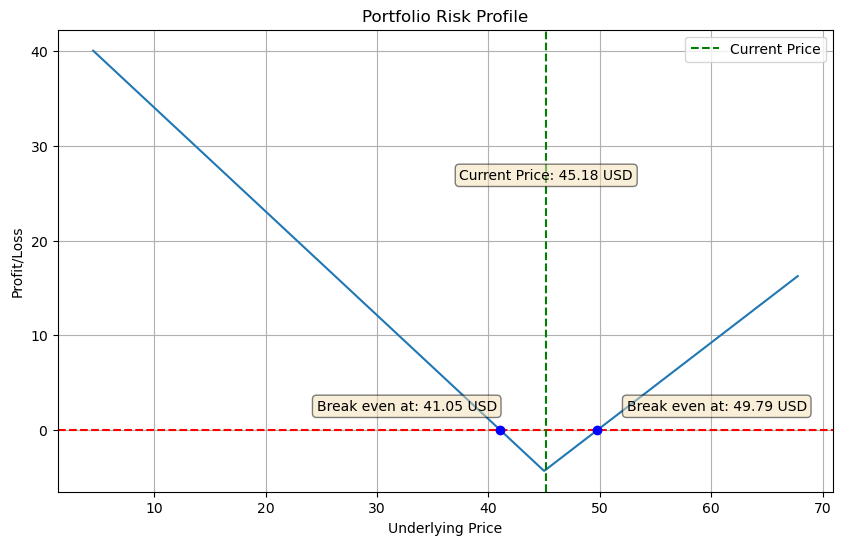

In [339]:
Payoff(filtered_calls,filtered_puts)